# Определение перспективного тарифа для телеком-компании

**Цель** – определение выгодного тарифного плана для корректировки рекламного бюджета.

**Задачи:**
- обзор и предобработка данных;
- расчёт характеристик для каждого пользователя;
- анализ метрик;
- проверка гипотез:
    - равенства среднего выручек тарифов;
    - равенства среднего выручек Москвы и других регионов.

**Данные:** данные 500 пользователей тарифных планов «Смарт» и «Ультра» за 2018 год.

- Таблица users (информация о пользователях):
    - user_id — уникальный идентификатор пользователя
    - first_name — имя пользователя
    - last_name — фамилия пользователя
    - age — возраст пользователя (годы)
    - reg_date — дата подключения тарифа (день, месяц, год)
    - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    - city — город проживания пользователя
    - tariff — название тарифного плана

- Таблица calls (информация о звонках):
    - id — уникальный номер звонка
    - call_date — дата звонка
    - duration — длительность звонка в минутах
    - user_id — идентификатор пользователя, сделавшего звонок

- Таблица messages (информация о сообщениях):
    - id — уникальный номер сообщения
    - message_date — дата сообщения
    - user_id — идентификатор пользователя, отправившего сообщение

- Таблица internet (информация об интернет-сессиях):
    - id — уникальный номер сессии
    - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    - session_date — дата интернет-сессии
    - user_id — идентификатор пользователя

- Таблица tariffs (информация о тарифах):
    - tariff_name — название тарифа
    - rub_monthly_fee — ежемесячная абонентская плата в рублях
    - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    - messages_included — количество сообщений в месяц, включённых в абонентскую плату
    - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)
    
**Примечание**: 
- «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт:
- Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. 
- Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Предобработка данных

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as mt
from scipy import stats as st

pd.options.display.float_format = '{:.3f}'.format

In [2]:
# Импорт данных
users = pd.read_csv('00_Data/users.csv')
calls = pd.read_csv('00_Data/calls.csv')
messages = pd.read_csv('00_Data/messages.csv')
internet = pd.read_csv('00_Data/internet.csv')
tariffs = pd.read_csv('00_Data/tariffs.csv')

In [3]:
# Функция обзора данных
def first_look(df):
    print('----------Первые 5 строк----------')
    display(df.head())
    print('\n')
    print('----------Тип данных----------')
    display(df.info())
    print('\n')
    print('----------Пропуски в данных----------')
    df_isna = df.isna().sum()
    if df_isna.sum().sum() > 0:
        display(df_isna.loc[df_isna > 0])
    else: print('Пропусков нет')
    print('\n')
    print('----------Дубликаты----------')
    if df.duplicated().sum() > 0:
        print('Дубликатов:', df.duplicated().sum())
    else:
        print('Дубликатов нет')
    print('\n')
    print('----------Количество клиентов----------')
    print('Количество клиентов:', df['user_id'].nunique())

In [4]:
# Обзор данных
first_look(users)

----------Первые 5 строк----------


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None



----------Пропуски в данных----------


churn_date    462
dtype: int64



----------Дубликаты----------
Дубликатов нет


----------Количество клиентов----------
Количество клиентов: 500


In [5]:
first_look(calls)

----------Первые 5 строк----------


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.000,1000
1,1000_1,2018-08-17,0.000,1000
2,1000_2,2018-06-11,2.850,1000
3,1000_3,2018-09-21,13.800,1000
4,1000_4,2018-12-15,5.180,1000




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None



----------Пропуски в данных----------
Пропусков нет


----------Дубликаты----------
Дубликатов нет


----------Количество клиентов----------
Количество клиентов: 492


In [6]:
first_look(messages)

----------Первые 5 строк----------


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None



----------Пропуски в данных----------
Пропусков нет


----------Дубликаты----------
Дубликатов нет


----------Количество клиентов----------
Количество клиентов: 426


In [7]:
first_look(internet)

----------Первые 5 строк----------


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.950,2018-11-25,1000
1,1,1000_1,1052.810,2018-09-07,1000
2,2,1000_2,1197.260,2018-06-25,1000
3,3,1000_3,550.270,2018-08-22,1000
4,4,1000_4,302.560,2018-09-24,1000




----------Тип данных----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None



----------Пропуски в данных----------
Пропусков нет


----------Дубликаты----------
Дубликатов нет


----------Количество клиентов----------
Количество клиентов: 497


In [8]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


**Выводы**

**`users`**
- в столбце `churn_date` есть пропуски, которые означают, что клиент не перестал пользоваться тарифом;
- необходимо преобразовать `reg_date` в формат datetime;
- необходимо выделить столбец со значением месяца.

**`calls`**
- необходимо преобразовать `call_date` в формат datetime;
- необходимо выделить столбец со значением месяца;
- необходимо округлить минуты в большую сторону;
- наблюдаются нулевые значения длительности звонков.

**`messages`**
- преобразовать `message_date` в datetime;
- необходимо выделить столбец со значением месяца.

**`internet`**
- удалить столбец `id` - видимо это индексы;
- преобразовать `session_date` в datetime;
- необходимо выделить столбец со значением месяца;
- необходимо перевести мб в гб и округлить в большую сторону.

**`tariffs`**
- всё нормально.



**Ни в одной таблице количество клиентов не совпадает с 500.**

## Приведение данных 

### Ошибки и типы данных

- Привидение данных к нужным типам;
- поиск и исправление ошибок в данных, если они есть.

#### Проверка количества клиентов

Проверим все ли клиенты в наблюдаются в таблице с информацией о пользователях.

In [9]:
# Спискок уникальных клиентов
users_all = users['user_id'].unique()

# Спискок уникальных клиентов в calls
users_calls_list = calls['user_id'].unique()

# Спискок уникальных клиентов в messages
users_messages_list = messages['user_id'].unique()

# Спискок уникальных клиентов в internet
users_internet_list = internet['user_id'].unique()

users_lists = [users_calls_list, users_messages_list, users_internet_list]

# Цикл для проверки наличия user_id таблицы users в таблицах calls, messages, internet.
# Цикл по массивам уникальных клиентов - звонки, сообщения, интернет
for users_list in users_lists:
    users_itog = []

    # Цикл по массиву
    for user_id in users_list:
        # Если user_id встречается в users_all и его нет в users_itog
        if user_id in users_all and user_id not in users_itog:
            users_itog.append(user_id)
    print(len(users_list) - len(users_itog))

0
0
0


Это означет, что все клиенты в таблицах calls, messages, internet присутствуют в таблице users.

#### `users`

In [10]:
# Преобразование в datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

# Выделение столбца с месяцем
users['month'] = pd.DatetimeIndex(users['reg_date']).month

users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


Данные преобразованы.

#### `calls`

In [11]:
# Преобразование в datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

# Выделение столбца с месяцем
calls['month_num'] = pd.DatetimeIndex(calls['call_date']).month

# Добавление столбца с началом календарного месяца
calls['month'] = calls['call_date'].astype('datetime64[M]')

# Округление минут в большую сторону
calls['duration'] = np.ceil(calls['duration']).astype('int')

calls.head()

,id,call_date,duration,user_id,month_num,month
0,1000_0,2018-07-25,0,1000,7,2018-07-01
1,1000_1,2018-08-17,0,1000,8,2018-08-01
2,1000_2,2018-06-11,3,1000,6,2018-06-01
3,1000_3,2018-09-21,14,1000,9,2018-09-01
4,1000_4,2018-12-15,6,1000,12,2018-12-01


In [12]:
# Функция для построения гистограммы и диаграммы размаха
def hist_maker(column, bins):
    print(column.describe())
    plt.figure(figsize=(10,6))
    plt.hist(column, bins=bins, color='grey', edgecolor='grey', alpha=0.8)
    plt.axvline(column.describe()['mean'], color='r', linestyle='dashed', linewidth=3, label='Mean value: {:.2f}'.format(column.describe()['mean']))
    plt.axvline(column.describe()['50%'], color='b', linestyle='dotted', linewidth=3, label='Median value: {:.0f}'.format(column.describe()['50%']))
    plt.xlabel(column.name)
    plt.ylabel('count')
    plt.legend()
    plt.title('Histogramm {}'.format(column.name))
    plt.figure(figsize=(20,2))
    sns.boxplot(x=column)
    plt.title('Boxplot {}'.format(column.name))

count   202607.000
mean         7.158
std          5.959
min          0.000
25%          2.000
50%          6.000
75%         11.000
max         38.000
Name: duration, dtype: float64


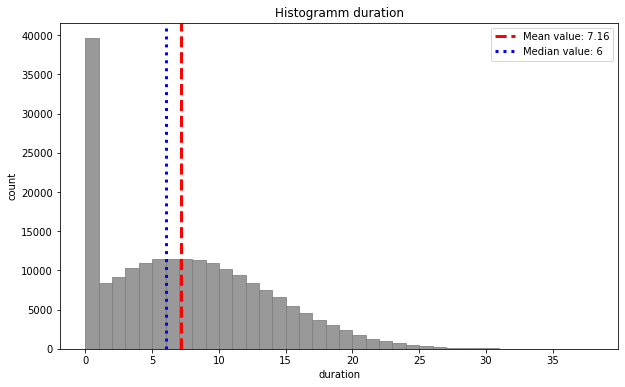

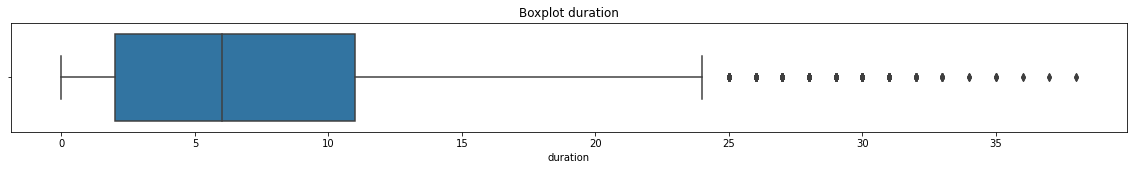

In [13]:
hist_maker(calls['duration'], 38)

- Данные преобразованы;
- На гистограмме выскакаивают нулевые значения - это пропущенные звонки.

#### `messages`

In [14]:
# Преобразование в datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

# Выделение столбца с месяцем
messages['month_num'] = pd.DatetimeIndex(messages['message_date']).month

# Добавление столбца с началом календарного месяца
messages['month'] = messages['message_date'].astype('datetime64[M]')

messages.head()

,id,message_date,user_id,month_num,month
0,1000_0,2018-06-27,1000,6,2018-06-01
1,1000_1,2018-10-08,1000,10,2018-10-01
2,1000_2,2018-08-04,1000,8,2018-08-01
3,1000_3,2018-06-16,1000,6,2018-06-01
4,1000_4,2018-12-05,1000,12,2018-12-01


In [15]:
# Группировка таблицы для получения ежемесячного количества сообщений каждого пользователя
messages_count = messages.groupby(['user_id','month']).agg(messages = ('id', 'count')).reset_index()
messages_count.head()

,user_id,month,messages
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


count   2717.000
mean      45.284
std       35.051
min        1.000
25%       19.000
50%       38.000
75%       63.000
max      224.000
Name: messages, dtype: float64


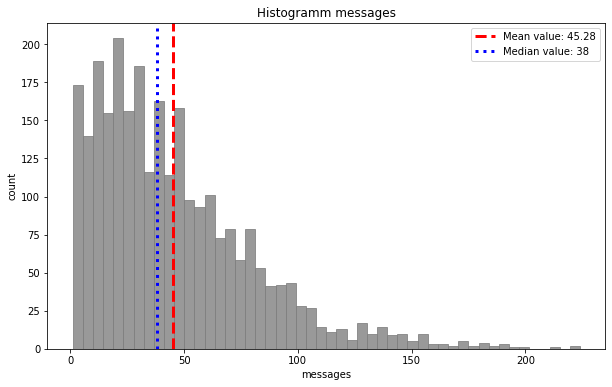

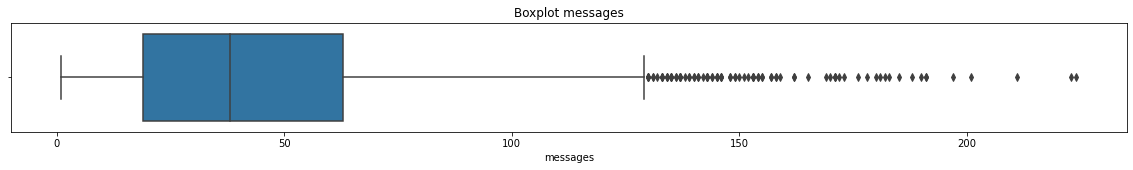

In [16]:
hist_maker(messages_count['messages'], 50)

#### `internet`

In [17]:
# Преобразование в datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

# Выделение столбца с месяцем
internet['month_num'] = pd.DatetimeIndex(internet['session_date']).month

# Добавление столбца с началом календарного месяца
internet['month'] = internet['session_date'].astype('datetime64[M]')

# Удаление столбца с порядковыми номерами
internet = internet.drop('Unnamed: 0', axis=1)

# Преобразование мегабайт в гигабайты
internet['gb_used'] = internet['mb_used'] / 1024
      
# Округление gb
internet['gb_used'] = np.ceil(internet['gb_used']).astype('int')

internet.head()

,id,mb_used,session_date,user_id,month_num,month,gb_used
0,1000_0,112.950,2018-11-25,1000,11,2018-11-01,1
1,1000_1,1052.810,2018-09-07,1000,9,2018-09-01,2
2,1000_2,1197.260,2018-06-25,1000,6,2018-06-01,2
3,1000_3,550.270,2018-08-22,1000,8,2018-08-01,1
4,1000_4,302.560,2018-09-24,1000,9,2018-09-01,1


count   149396.000
mean       370.192
std        278.301
min          0.000
25%        138.188
50%        348.015
75%        559.553
max       1724.830
Name: mb_used, dtype: float64


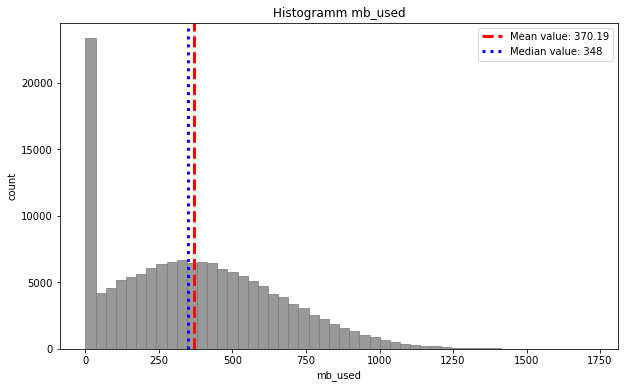

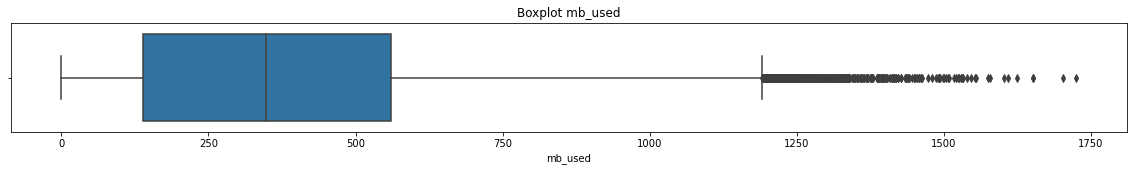

In [18]:
hist_maker(internet['mb_used'], 50)

In [19]:
# Помесячное рассмотрение объема интернета пользователей
gb_count = internet.groupby(['user_id', 'month']).agg(gb=('gb_used', 'sum')).reset_index()
gb_count.head()

,user_id,month,gb
0,1000,2018-05-01,4
1,1000,2018-06-01,49
2,1000,2018-07-01,28
3,1000,2018-08-01,27
4,1000,2018-09-01,26


count   3203.000
mean      41.256
std       16.463
min        0.000
25%       31.000
50%       42.000
75%       52.000
max      101.000
Name: gb, dtype: float64


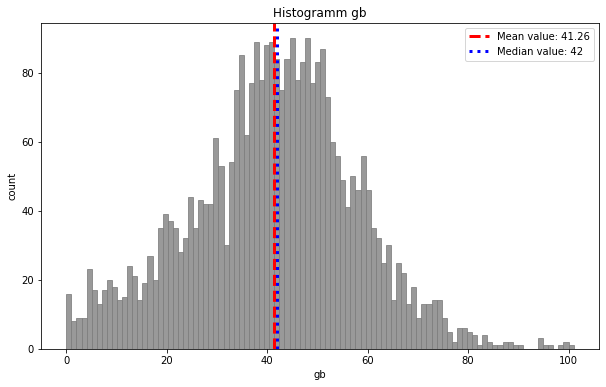

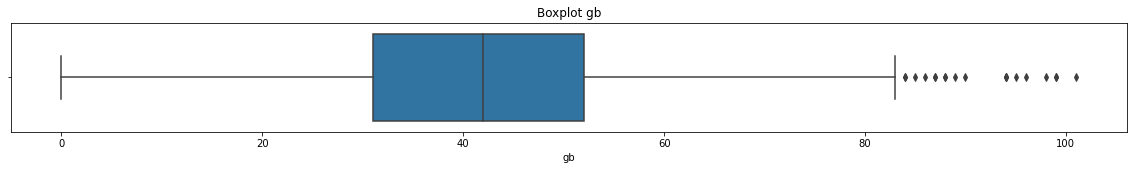

In [20]:
hist_maker(gb_count['gb'], 100)

- Мегабайты преобразованы в гигабайты;
- Наблюдается большое количество нулевых значений объема использованного интернета, что может быть связано с тем, что клиент не пользовался интернетом в этот день.

### Расчет характеристик для каждого пользователя

**Расчётные характеристики:**
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячная выручка с каждого пользователя.

#### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [21]:
# Количество сделанных звонков и израсходованных минут по месяцам
calls_month_count = (calls.groupby(['user_id', 'month'])
                     .agg(calls_count=('id', 'count'), calls_duration=('duration', 'sum'))
                     .reset_index())
calls_month_count.head()

,user_id,month,calls_count,calls_duration
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466


#### Количество отправленных сообщений по месяцам

In [22]:
# Ранее было рассчитано
messages_count_month = messages.groupby(['user_id', 'month']).agg(messages_count=('id', 'count')).reset_index()
messages_count_month.head()

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57


#### Объем израсходованного интернет-трафика по месяцам

In [23]:
# Ранее было рассчитано
gb_month_count = internet.groupby(['user_id', 'month']).agg(gb_count=('gb_used', 'sum')).reset_index()
gb_month_count.head()

,user_id,month,gb_count
0,1000,2018-05-01,4
1,1000,2018-06-01,49
2,1000,2018-07-01,28
3,1000,2018-08-01,27
4,1000,2018-09-01,26


#### Помесячная выручка с каждого пользователя 

##### Объеденение calls, messages, intrnet по user_id

In [24]:
# Объединение таблиц calls_month_count, messages_count_month, data_merge
data_merge = pd.merge(calls_month_count, messages_count_month, how='outer', on=['user_id', 'month'])
data_merge = pd.merge(data_merge, gb_month_count, how='outer', on=['user_id', 'month'])
data_merge

,user_id,month,calls_count,calls_duration,messages_count,gb_count
0,1000,2018-05-01,22.000,159.000,22.000,4.000
1,1000,2018-06-01,43.000,172.000,60.000,49.000
2,1000,2018-07-01,47.000,340.000,75.000,28.000
3,1000,2018-08-01,52.000,408.000,81.000,27.000
4,1000,2018-09-01,58.000,466.000,57.000,26.000
...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,NaN,32.000,50.000
3210,1489,2018-10-01,NaN,NaN,21.000,52.000
3211,1489,2018-11-01,NaN,NaN,20.000,46.000
3212,1489,2018-12-01,NaN,NaN,35.000,45.000


In [25]:
# Оценка количества пропусков
data_merge.isna().sum()

user_id             0
month               0
calls_count        40
calls_duration     40
messages_count    497
gb_count           11
dtype: int64

Буду считать, что пропуски в данных означают то, что клиент не пользовался этим видом связи в каком-либо из месяцев. Также буду учитывать, что некоторые user_id я удалял ранее. Они могли при объеденении пересечься.

In [26]:
data_merge = data_merge.fillna(0)
data_merge.isna().sum()

user_id           0
month             0
calls_count       0
calls_duration    0
messages_count    0
gb_count          0
dtype: int64

Пропуски в данных устранены.

In [27]:
# Доля оставшихся клиентов после преобразований
print('Доля оставшихся клиентов после преобразований',round(data_merge['user_id'].nunique() / len(users) * 100, 2),'%')

Доля оставшихся клиентов после преобразований 99.6 %


##### Объеденение имен тарифов по user_id

In [28]:
data_merge = pd.merge(data_merge, users[['user_id', 'tariff']], how='left', on='user_id')
data_merge

,user_id,month,calls_count,calls_duration,messages_count,gb_count,tariff
0,1000,2018-05-01,22.000,159.000,22.000,4.000,ultra
1,1000,2018-06-01,43.000,172.000,60.000,49.000,ultra
2,1000,2018-07-01,47.000,340.000,75.000,28.000,ultra
3,1000,2018-08-01,52.000,408.000,81.000,27.000,ultra
4,1000,2018-09-01,58.000,466.000,57.000,26.000,ultra
...,...,...,...,...,...,...,...
3209,1489,2018-09-01,0.000,0.000,32.000,50.000,smart
3210,1489,2018-10-01,0.000,0.000,21.000,52.000,smart
3211,1489,2018-11-01,0.000,0.000,20.000,46.000,smart
3212,1489,2018-12-01,0.000,0.000,35.000,45.000,smart


Посчитаем количество пользователей оставшихся после объеденения.

In [29]:
data_merge['user_id'].nunique()

498

Их меньше, чем должно быть. Проверим двух, которые не вошли в объедененную таблицу. Пользовались ли они чем-нибудь?

In [30]:
users[users['user_id'].isin(data_merge['user_id'].unique()) == False]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,12


In [31]:
messages[messages['user_id'].isin(data_merge['user_id'].unique()) == False]

,id,message_date,user_id,month_num,month


In [32]:
calls[calls['user_id'].isin(data_merge['user_id'].unique()) == False]

,id,call_date,duration,user_id,month_num,month


In [33]:
internet[internet['user_id'].isin(data_merge['user_id'].unique()) == False]

,id,mb_used,session_date,user_id,month_num,month,gb_used


Не вошедшие два клиента так и не вомпользовались услугами телеком компании.

##### Объеденение таблицы с информацией о тарифах

In [34]:
# Переименование столбца в таблице с характеристиками тарифов
tariffs = tariffs.rename(columns={'tariff_name' : 'tariff'})

# Объеденение
data_merge = pd.merge(data_merge, tariffs, how='inner', on='tariff')
data_merge.head()

,user_id,month,calls_count,calls_duration,messages_count,gb_count,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,22.000,159.000,22.000,4.000,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,43.000,172.000,60.000,49.000,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,47.000,340.000,75.000,28.000,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,52.000,408.000,81.000,27.000,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,58.000,466.000,57.000,26.000,ultra,1000,30720,3000,1950,150,1,1


##### Расчет выручки

Рассчитаем выручку:
- Вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
- Остаток умножаем на значение из тарифного плана;
- Прибавляем абонентскую плату, соответствующую тарифному плану.

In [35]:
# Функция для расчета выручки от каждого клиента за месяц
def revenue(row):
    revenue = row['rub_monthly_fee']
    if (row['calls_duration'] > row['minutes_included']):
        revenue += (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    if (row['messages_count'] > row['messages_included']):
        revenue += (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    if (row['gb_count'] > row['mb_per_month_included'] / 1024):
        revenue += (row['gb_count'] - row['mb_per_month_included'] / 1024) * row['rub_per_gb']
    return round(revenue, 2)

In [36]:
# Применение функции
data_merge['revenue'] = data_merge.apply(revenue, axis=1)

In [37]:
data_merge.head(5)

,user_id,month,calls_count,calls_duration,messages_count,gb_count,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,2018-05-01,22.000,159.000,22.000,4.000,ultra,1000,30720,3000,1950,150,1,1,1950.000
1,1000,2018-06-01,43.000,172.000,60.000,49.000,ultra,1000,30720,3000,1950,150,1,1,4800.000
2,1000,2018-07-01,47.000,340.000,75.000,28.000,ultra,1000,30720,3000,1950,150,1,1,1950.000
3,1000,2018-08-01,52.000,408.000,81.000,27.000,ultra,1000,30720,3000,1950,150,1,1,1950.000
4,1000,2018-09-01,58.000,466.000,57.000,26.000,ultra,1000,30720,3000,1950,150,1,1,1950.000


Выручка расчитана.

## Анализ данных

В данном разделе посмотрим на поведение клиентов оператора:
- Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 
- Посчитаем среднее количество, дисперсию и стандартное отклонение. 
- Построем гистограммы и опишем распределения.

In [38]:
# Обозначение столбца с именем тарифа как индекс
# Будет использован в функции ниже для обозначения включенных в тариф количества звонков, сообщений и гигабайт
tariffs = tariffs.set_index('tariff')

In [39]:
# Перевод гигабайт в мегабайты
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024

In [40]:
# Функция для построения гистограммы, диаграммы размаха и таблицы со статистиками по тарифам
def hist_and_table_maker(data, characteristic, characteristic_included):
    
    # Создание группировки характеристики по тарифам
    cd = data.groupby('tariff')[characteristic]
    cd_desc = cd.describe(percentiles = [.01,.25,.75,.99])
    # Оценка со смещением, т.к. выборка
    cd_desc['var']= [np.var(cd.get_group('smart'), ddof=1), np.var(cd.get_group('ultra'), ddof=1)]
    display(cd_desc)
    
    # Создание гистограммы
    fig = plt.figure(figsize=(20,6))
    sns.histplot(data=data_merge, x=characteristic, hue='tariff')
    plt.axvline(cd_desc['mean'][0], color='orange', linestyle='dashed', linewidth=3, label='Mean smart: {:.2f}'.format(cd_desc['mean'][0]))
    plt.axvline(cd_desc['mean'][1], color='blue', linestyle='dashed', linewidth=3, label='Mean ultra: {:.2f}'.format(cd_desc['mean'][1]))
    plt.axvline(tariffs.at['ultra', characteristic_included], color='blue', linestyle='solid', linewidth=3, label='Included in tariff smart')
    plt.axvline(tariffs.at['smart', characteristic_included], color='orange', linestyle='solid', linewidth=3, label='Included in tariff ultra')
    plt.title('Histogramm {}'.format(characteristic))
    fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.87))
    
    # Создание диаграммы размаха
    plt.figure(figsize=(20,2))
    sns.boxplot(data=data_merge, x=characteristic, y='tariff')
    plt.title('Boxplot {}'.format(characteristic))

### Звонки

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2229.000,417.935,190.314,0.000,15.280,282.000,422.000,545.000,872.720,1435.000,36219.316
ultra,985.000,526.623,317.606,0.000,0.000,284.000,518.000,752.000,1291.120,1673.000,100873.633


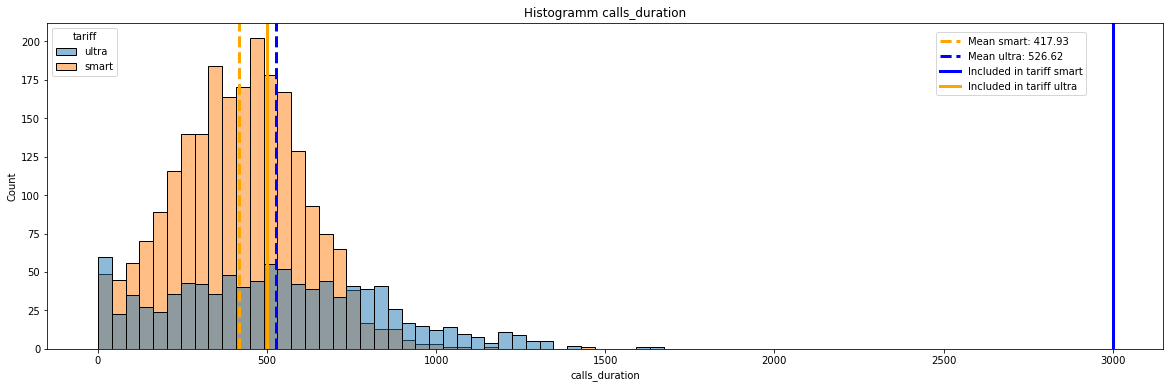

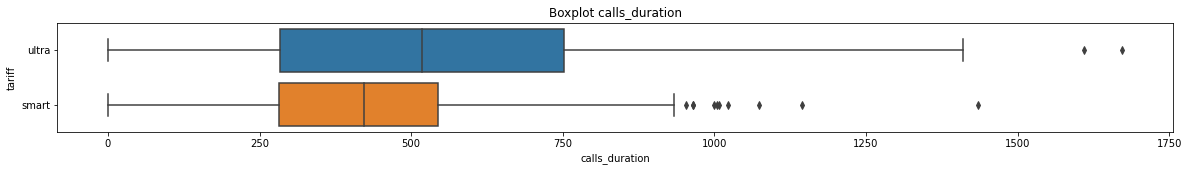

In [41]:
hist_and_table_maker(data_merge, 'calls_duration', 'minutes_included')

**Выводы**

- Среднее значение длительности звонков в тарифе ультра больше;
- Пользовтели тарифа ультра всегда укладываются в лимит;
- Лимит минут тарифа смарт близок к медианному значению;
- Дисперсия и стандартное отклонение тарифа ультра больше.

### Сообщения

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2229.000,33.384,28.228,0.000,0.000,10.000,28.000,51.000,108.000,143.000,796.813
ultra,985.000,49.363,47.804,0.000,0.000,6.000,38.000,79.000,183.320,224.000,2285.266


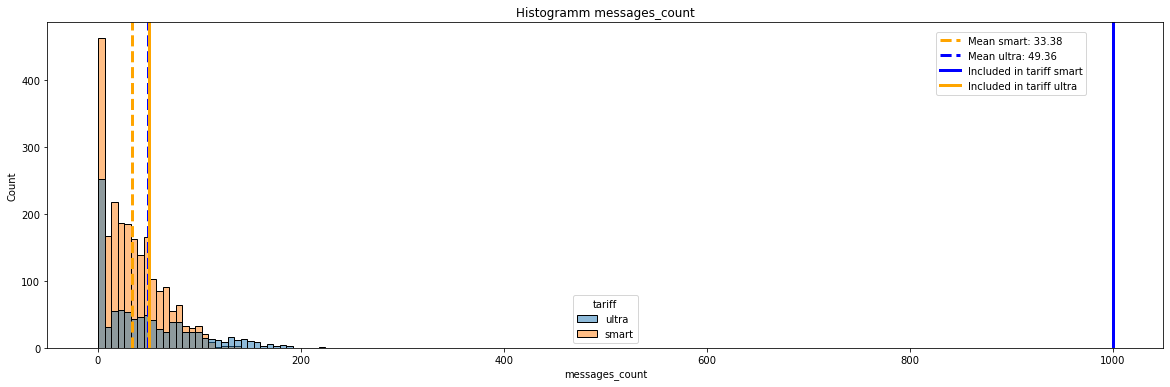

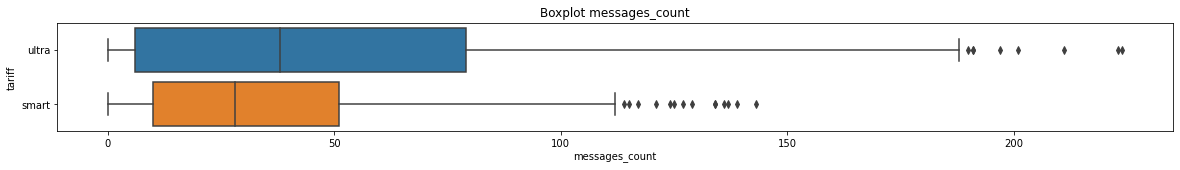

In [42]:
hist_and_table_maker(data_merge, 'messages_count', 'messages_included')

**Выводы**

- Значительная доля клиентов не пользуются сообщениями (много нулевых значений);
- Среднее значение количества сообщений больше в тарифе ультра;
- Дисперсия и среднеквадратическое отклонение больше в тарифе ультра;
- Пользователи тарифа ультра всегда укладываются в бесплатный лимит количества сообщений.

### Интернет

,count,mean,std,min,1%,25%,50%,75%,99%,max,var
tariff,,,,,,,,,,,
smart,2229.000,42.418,14.943,0.000,4.000,34.000,43.000,52.000,75.720,101.000,223.296
ultra,985.000,38.164,19.565,0.000,0.000,23.000,38.000,52.000,83.000,98.000,382.776


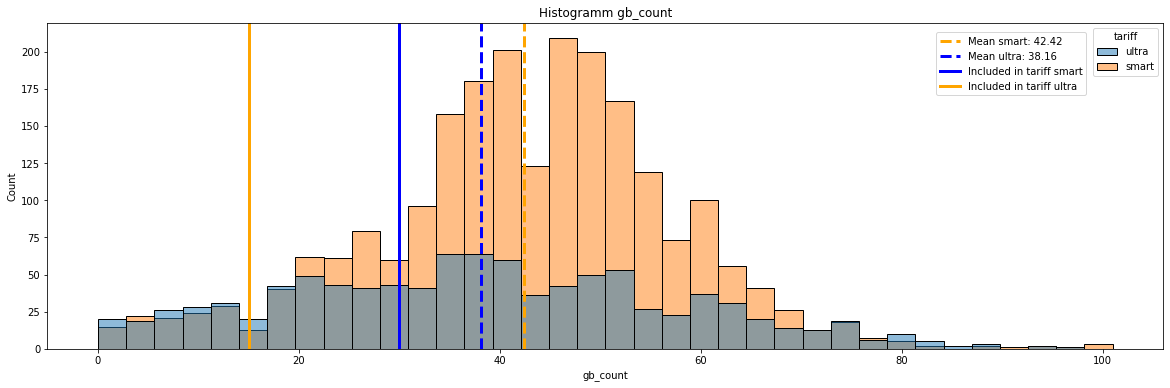

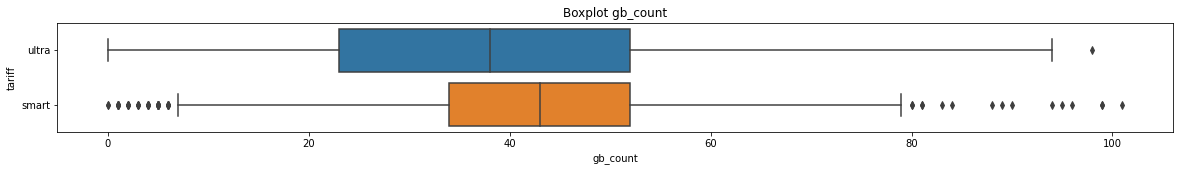

In [43]:
hist_and_table_maker(data_merge, 'gb_count', 'gb_per_month_included')

**Выводы**

- Среднее значение смарта выше;
- Дисперсия и среднеквадратическое отклонение выше у тарифа ультра;
- Ни в тарифе смарт, ни в тарифе ультра клиенты не укладываются в лимиты;
- В лимит смарта не укладывается болшая доля пользователей, чем в тарифе ультра.

## Проверка гипотез

### Проверка равенства средней выручки пользователей тарифов «Ультра» и «Смарт»

H0 - среднее значение выручки тарифа ультра равно среднему значению тарифа смарт.

H1 - среднее значение выручки тарифа ультра НЕ равно среднему значению тарифа смарт.

Для сопоставления средних генеральных совокупностей по взятым из них независимым выборкам используется метод `scipy.stats.ttest_ind()`.

In [44]:
# Категоризация
revenue_ultra = data_merge[data_merge['tariff'] == 'ultra']['revenue']
revenue_smart = data_merge[data_merge['tariff'] == 'smart']['revenue']

In [45]:
# Расчет дисперсии
print('Дисперсия для ultra', round(np.var(revenue_ultra), 0))
print('Дисперсия для smart', round(np.var(revenue_smart), 0))

Дисперсия для ultra 4687395.0
Дисперсия для smart 8369844.0


Дисперсии отличаются достаточно сильно, поэтому equal_var поставлю равным False (дисперсия будет оценена по объедененному датасету из двух выборок).

In [46]:
# t-test_ind
alpha = .05
results = st.ttest_ind(revenue_ultra, revenue_smart, equal_var = False)
print('p_value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвержение нулевой гипотезы')
else:
    print('Принятие нулевой гипотезы')

p_value: 3.366123216919074e-132
Отвержение нулевой гипотезы


In [47]:
print('revenue_ultra', round(revenue_ultra.mean(), 0))
print('revenue_smart', round(revenue_smart.mean(), 0))

revenue_ultra 3844.0
revenue_smart 6247.0


Средняя выручка пользователей тарифов «Ультра» и «Смарт» ИМЕЕТ статистически значимые различия.

In [48]:
print('revenue_ultra_sum', round(revenue_ultra.sum(), 0))
print('revenue_smart_sum', round(revenue_smart.sum(), 0))

revenue_ultra_sum 3786750.0
revenue_smart_sum 13924751.0


### Проверка равенства средней выручки пользователей из Москвы и пользователей из других регионов

In [49]:
# Создание датасета с user_id, revenue и регионом
data_region = pd.merge(data_merge[['user_id', 'revenue']], users[['user_id', 'city']],
                       how='inner', on='user_id')
data_region.sample(5)

,user_id,revenue,city
2523,1338,4750.000,Москва
2549,1345,7750.000,Москва
2920,1433,6488.000,Подольск
2675,1384,9061.000,Нижний Новгород
1568,1127,3637.000,Казань


In [50]:
# Проверка на неявные дубликаты
#sorted(list(data_region['city'].unique()))
# Закоментил потому что вывод мешает

Неявных дубликатов нет.

In [51]:
# Категоризация выручки
data_moscow = data_region[data_region['city'] == 'Москва']['revenue']
data_other = data_region[~(data_region['city'] == 'Москва')]['revenue']

In [52]:
# Расчет дисперсии
print('Дисперсия для Москвы', round(np.var(data_moscow), 0))
print('Дисперсия для других городов', round(np.var(data_other), 0))

Дисперсия для Москвы 7188012.0
Дисперсия для других городов 8765039.0


Посчитаем долю различия дисперсий.

In [53]:
round(abs((np.var(data_moscow) - np.var(data_other))) / np.var(data_moscow), 2)

0.22

Дисперсии не сильно отличаются друг от друга, поэтому equal_var = True в t-test.

**Сформулируем гипотезы**

H0 - среднее значение выручки в Москве равно среднему значению выручки в других городах.

H1 - среднее значение выручки в Москве НЕ равно среднему значению выручки в дугих городах.

In [54]:
# t-test_ind
alpha = .05
results = st.ttest_ind(data_moscow, data_other)
print('p_value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвержение нулевой гипотезы')
else:
    print('Принятие нулевой гипотезы')

p_value: 0.28336464606572015
Принятие нулевой гипотезы


Средняя выручка пользователей из Москвы и пользователей из других регионов НЕ имеет статистические значимые различия.

## Выводы

**Обработка и исследовательский анализ данных:**
- Дубликы не были обнаружены.
- Пропусков в данных, которые надо было заменять на предварительном этапе не обнаружено.
- Выделены столбцы со значением календарного месяца (datetime) и номера месяца.
- Выполнены необходимые преобразования в формате данных.
- В большую сторону округлены минуты.
- Мегабайты переведы в гигабайты с учетом условий тарифов.
- Количество пользователей в данных по разным характеристикам несоответствовало их общему количеству в 500 пользователей, однако, в каждой таблице пользователи уникальны и имеются в списке клиентов `users`.
- На гистограмме продолжительности звонков наблюдается большое количество нулевых значений и как сказано в описании это пропущенные звонки.
- В датасете сообщений удалены клиенты с аномальным количеством сообщений в месяц.
- На гистограмме использованных мегабайт интернета в день выдеяются нулевые значения, которые могут быть связаны с тем, что клиент не пользовался мобильным интернетом в этот день.
- Устранены аномальные значения в таблице internet.
- После удаления аномалий проведен перерасчет помесячных значений характеристик.
- Рассчитана выручка.

**Главные выводы**
- Среднее значение длительности звонков и количества сообщений в тарифе ультра больше.
- Пользовтели тарифа ультра всегда укладываются в лимит сообщейни и длительности звонков.
- Значительная доля клиентов не пользуется сообщениями (много нулевых значений).
- Среднее значение использованных гигабайт в тарифе смарт выше.
- Дисперсия и среднеквадратическое отклонение у тарифа ультра больше по всем характеристикам.
- Ни в тарифе смарт, ни в тарифе ультра клиенты не укладываются в лимиты предоставленных за основную стоимость гигабайт.
- В лимит интернета смарта не укладывается бОлшая доля пользователей, чем в тарифе ультра.
- Среднее значение выручки тарифов ультра и смарт ИМЕЕТ статистически значимое различие.
- Средняя выручка пользователей из Москвы и пользователей из других регионов НЕ имеет статистически значимого различия.</span>
- Тариф смарт выгоднее тарифа ультра.

**Рекомендации**
- Рассмотреть выручку по характеристикам (звонки, сообщения, интернет).
- Рассмотреть выручку до лимитов и после - проверить насколько ощутима выручка с клиентов после исчерпания ими лимитов.
- *Для тарифа ультра:*
    -  Понизить лимит включенных в тариф количество минут до 1300 и сообщений до 160, а также повысить лимит включенных гигабайт до 80 (для удобства клиентов).
- *Для тарифа смарт:*
    -  Повысить лимит включенных в тариф количество минут до 900, сообщений до 110, гигабайт до 75 (для удобства клиентов).
- Осуществить односторонние гипотезы. С целью проверки статистически значимых различий средней выручки до и после внесенных рекомендуемых измененией в тариф.
- Осуществить анализ основных статистических характеристик тарифов и выручки по городам. Таких как среднее, медианное значение, различные перцентили, а также построение гистограмм с целью анализа различий между городами, оценки "портрета" регионального клиента, и возможной последующей корректировкой тарифов под регионы.